# Detecting the anomalous activity of a ship’s engine

This project applies statistical and machine learning techniques to detect anomalies in ship engine telemetry, with the goal of preventing malfunctions, reducing fuel consumption, and minimising safety risks.

## Business context

The dataset includes six features used to monitor ship engine performance:

- **Engine rpm** – May signal mechanical stress or power issues.
- **Lubrication oil pressure** – Low values suggest friction; high may indicate blockages.
- **Fuel pressure** – Affects combustion and fuel efficiency.
- **Coolant pressure** – Irregularities can signal leaks or overheating.
- **Lubrication oil temperature** – Reflects oil condition and heat management.
- **Coolant temperature** – Indicates engine heat regulation.

Anomalies typically affect 1%–5% of records. Early detection helps prevent downtime and safety risks.

# Import Required Libraries and Load Data

In [ ]:
# Import the required libraries.

# Data manipulation
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Feature scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Dimensionality reduction
from sklearn.decomposition import PCA

# Anomaly detection models
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [ ]:
# URL to import dataset from GitHub
url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(url)

# View the dimensions of the dataset
print("Dataset shape:", df.shape)

# Display the first few rows to check it's loaded correctly
df.head()

Dataset shape: (19535, 6)


Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         682          2.391656       4.617196          2.848982   
1         605          5.466877       6.424361          5.727520   
2         658          3.434232       3.680896          1.678708   
3         749          2.094656       7.120927          1.639670   
4         676          3.538228       5.956472          3.225336   

   lub oil temp  Coolant temp  
0     76.272417     69.884609  
1     73.222679     74.907314  
2     88.089916     78.704806  
3     77.661625     82.386700  
4     75.226352     67.153220

# Exploratory Data Analysis

## Missing and Duplicate Values

In [ ]:
# View the metadata with the info function.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


There are no missing values, as all columns have 19,535 non-null entries, matching the total row count.

In [ ]:
# Checking for uplicate values.
duplicate_rows = df.duplicated().sum()
print("Number of Duplicate Rows:", duplicate_rows)


Number of Duplicate Rows: 0


The values have high precision (many decimal places), making it unlikely for two rows to be identical. In our case we has 0 duplicates and so we can safely move on.

## Descriptive statistics

In [ ]:
# Generate descriptive statistics
df.describe()

Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
count  19535.000000      19535.000000   19535.000000      19535.000000   
mean     791.239263          3.303775       6.655615          2.335369   
std      267.611193          1.021643       2.761021          1.036382   
min       61.000000          0.003384       0.003187          0.002483   
25%      593.000000          2.518815       4.916886          1.600466   
50%      746.000000          3.162035       6.201720          2.166883   
75%      934.000000          4.055272       7.744973          2.848840   
max     2239.000000          7.265566      21.138326          7.478505   

       lub oil temp  Coolant temp  
count  19535.000000  19535.000000  
mean      77.643420     78.427433  
std        3.110984      6.206749  
min       71.321974     61.673325  
25%       75.725990     73.895421  
50%       76.817350     78.346662  
75%       78.071691     82.915411  
max       89.580796    195.527912

Quick Observations

- **Engine rpm** has a wide range (**61 to 2239**), suggesting potential outliers.
- **Coolant temperature** reaches a maximum of **195.5**, which is significantly higher than Q3 (**82.9**)—indicating extreme outliers.
- **Fuel pressure and coolant pressure** also show **high maximum values compared to Q3**, warranting further investigation.

Next, we will use visualisations to confirm these potential anomalies.


## Visualisation

### Boxplot

The boxplot is good for identifying outpliers and understand the data spread.

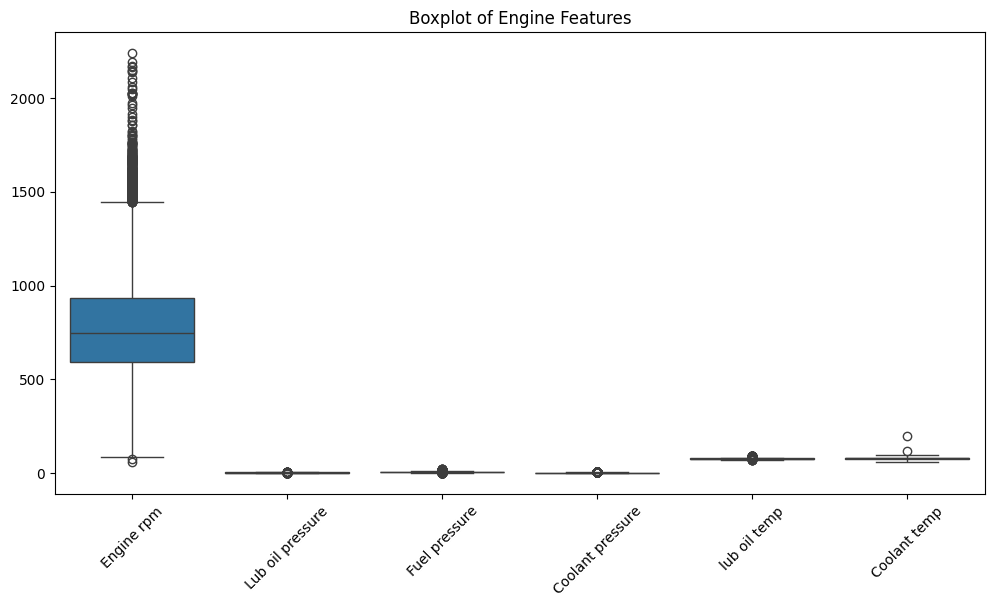

In [ ]:
# Boxplot for engine features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)

plt.title("Boxplot of Engine Features")
plt.xticks(rotation=45)
plt.show()


The scale difference for `Engine rpm` is making all other features compressed. To get around this, we can apply **feature scaling**.

- **Normalisation (MinMax Scaling):** Scales values between **0 and 1** which is best for **visualisation**.
- **Standardisation (Z-score Scaling):** Centers data to **mean = 0, std = 1** which is best for **ML anomaly detection models**.

Below is the same boxplot after applying normalisation, allowing for a clearer comparison between features.

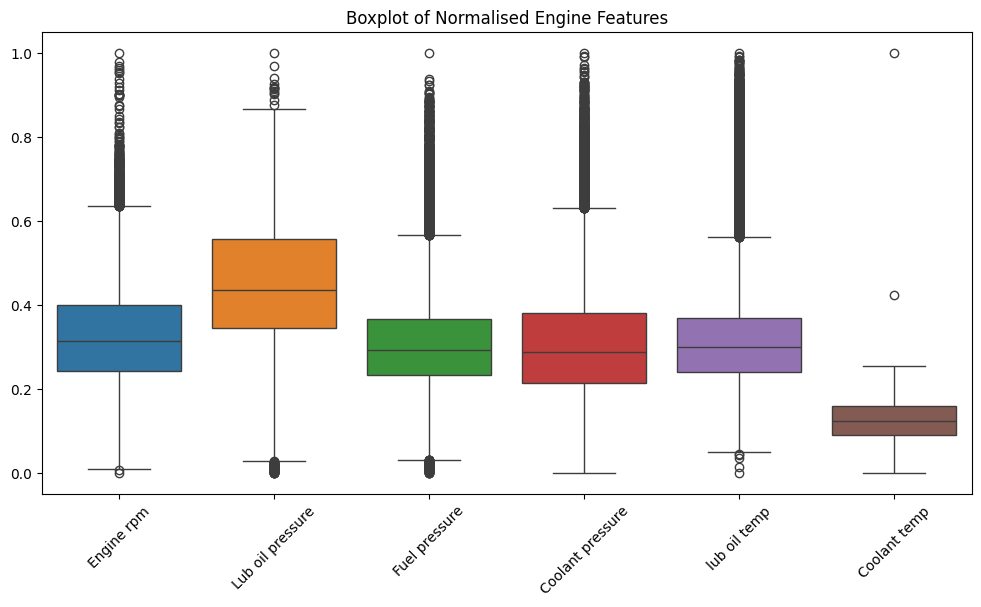

In [ ]:
# Min-max scaling.
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])  # Apply to all columns

# Alternative: Apply scaling only to specific columns (commented out)
# selected_columns = ['Engine rpm', 'Lub oil pressure', 'Fuel pressure',
#                     'Coolant pressure', 'lub oil temp', 'Coolant temp']
# df[selected_columns] = scaler.fit_transform(df[selected_columns])

# Replot the boxplot with normalised values
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)

plt.title("Boxplot of Normalised Engine Features")
plt.xticks(rotation=45)
plt.show()

Now we can clearly see outliers across all features, instead of just "Engine rpm" dominating.

- **Engine rpm** previously dominated the scale, but after normalisation, all features are now comparable.
- **Coolant temp** has fewer outliers but includes one extreme value.
- **Fuel pressure, coolant pressure, and lub oil temp** show **significant outliers above the upper whisker**.
- **Many features have lower-bound outliers**, suggesting some very low values exist.


### Histogram

Histograms show the distribution of each feature. Most importantly, they help identify whether a feature is normally distributed.

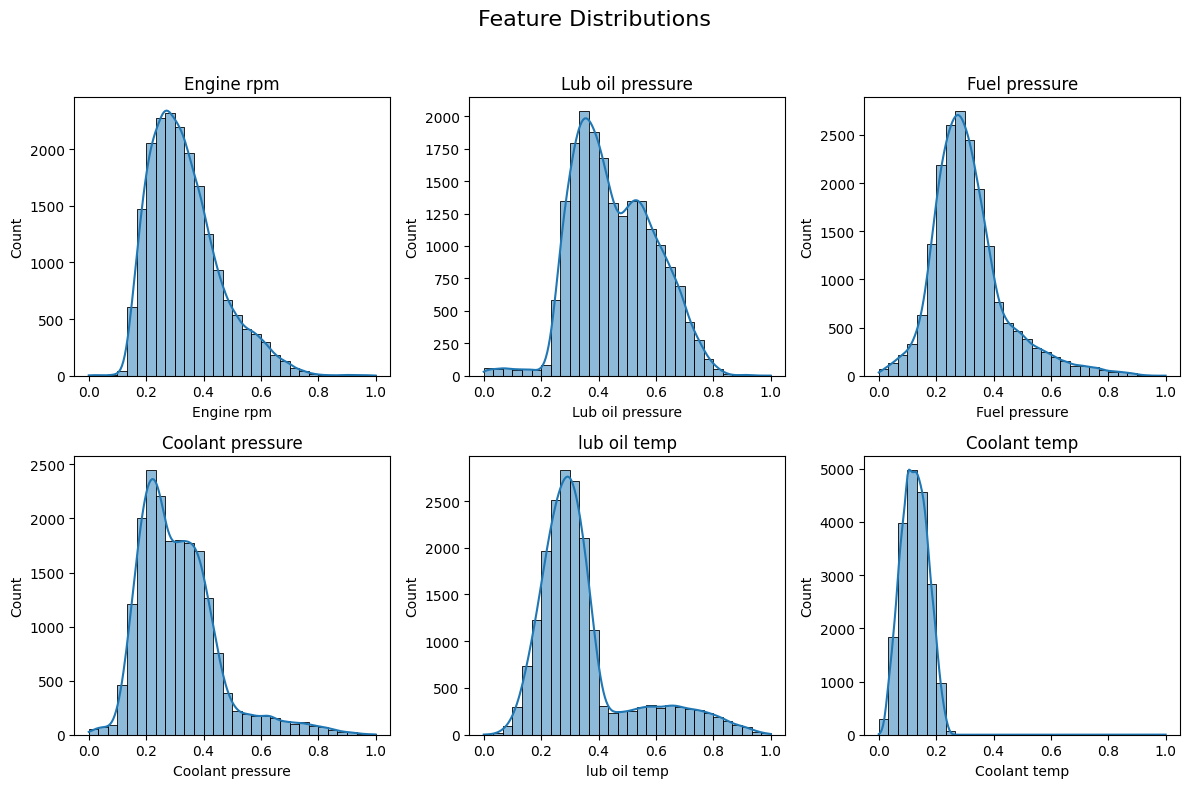

In [ ]:
# List of all features in the dataset
features = df.columns[:6]  # Use only first 6 features
#features = df.columns # We loop through features to dynamically plot each one, without hardcoding names.
#print(features)

# Create a 2-row, 3-column grid for subplots
# subplots() creates multiple plots in a grid layout inside one figure.
# figsize of (12, 8) normally works well for 2x3 grids
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
#print(type(fig)) # Figure object
#print(type(axes)) # NumPy array of AxesSubplot objects
#print(axes.shape) ## should be (2, 30 and is)
fig.suptitle("Feature Distributions", fontsize=16)  # Main title for all plots

# Loop through each feature and plot its histogram in the grid
for i, feature in enumerate(features): # enumerate() adds an index to each feature.
    #print(i, feature)
    row, col = divmod(i, 3)  # Determine subplot position (row, column)
    #print(row,col)
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[row, col])  # Plot histogram
    axes[row, col].set_title(feature)  # Set title for each subplot

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap with the main title
plt.show()


The histograms show that most features are not normally distributed. `Engine rpm`, `fuel pressure`, and `coolant temp` are right-skewed, while `lub oil temp` has a bimodal shape, suggesting different operating conditions. `Coolant temp` also has extreme high values, indicating possible anomalies.

Since the data does not follow a normal distribution, parametric methods like z-score or linear models may not be reliable. Instead, non-parametric approaches such as the IQR method, Isolation Forest, and One-Class SVM are more suitable. Feature scaling will also be important to ensure models handle different ranges properly.

### Scatter plot

Scatter plots check for relationships & linearity between features.

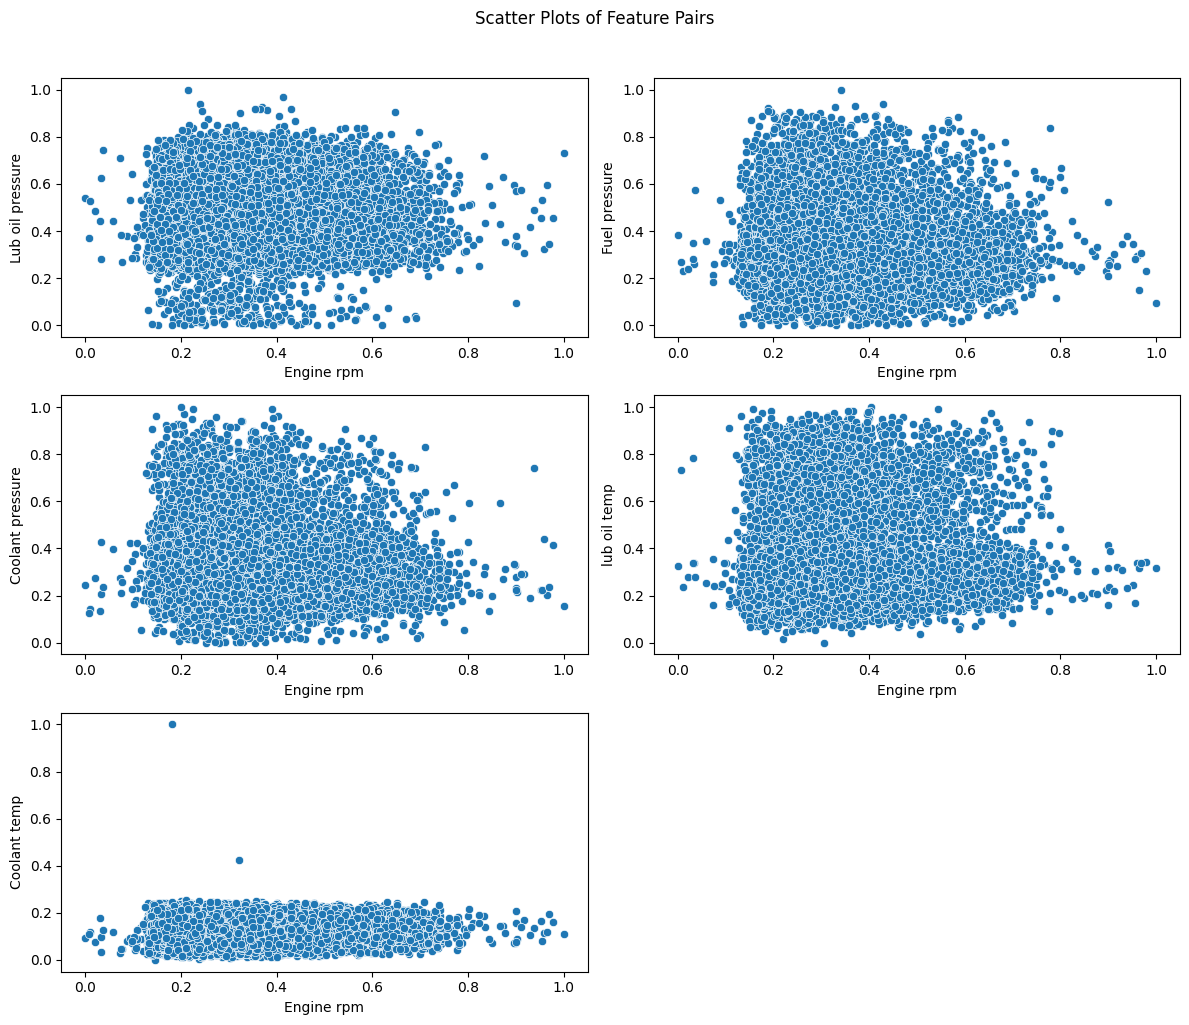

In [ ]:
# Scatter plot for each feature pair
plt.figure(figsize=(12, 10))

for i, feature in enumerate(df.columns[1:], start=1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=df[df.columns[0]], y=df[feature])
    plt.xlabel(df.columns[0])
    plt.ylabel(feature)

plt.suptitle("Scatter Plots of Feature Pairs", y=1.02)
plt.tight_layout()
plt.show()

The data points appear widely spread without strong correlations.

Additionally, given six features, a full pairwise scatter plot matrix would require **15** unique plots, making it impractical for detailed analysis.

Since scatter plots do not provide useful insights in this case, they will not be a focus in the final analysis.

### Correlation Heatmap

Heatmaps are useful to show any correlations between features.

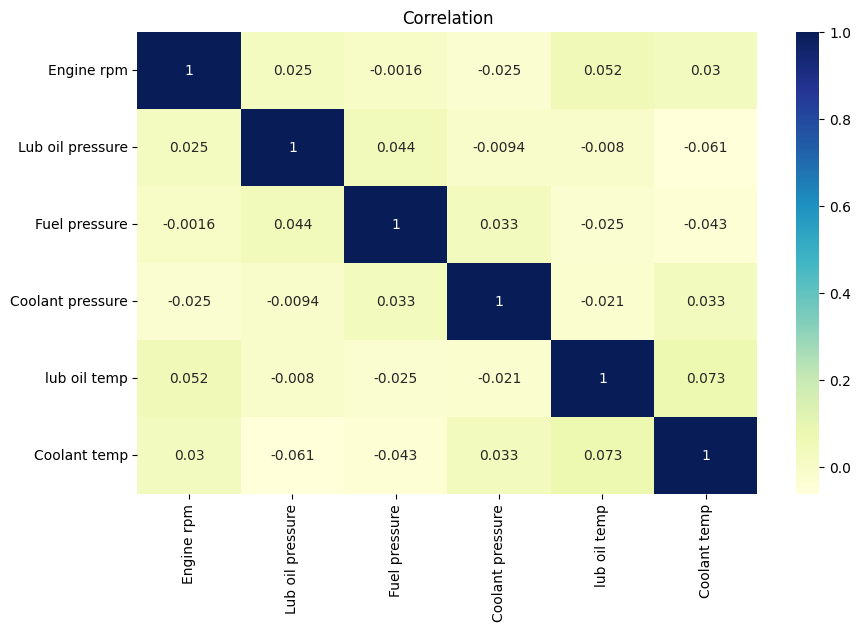

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

plt.title("Correlation")
plt.show()

The weak correlations suggest that the features are largely independent. Since there is no strong correlation between features, **dimensionality reduction (such as PCA) is not necessary**.  

PCA is a linear, unsupervised technique that transforms correlated features into a smaller number of uncorrelated components. However, as our dataset lacks strong correlations, each feature can be analysed individually for anomaly detection.


# Anomaly detection: Statistical methods

## Choice of Statistical Method for Anomaly Detection

The **IQR method** is chosen to detect outliers because it is a simple, **univariate** statistical method that identifies extreme values based on **statistical dispersion** (the difference between the 75th and 25th percentiles). Given that the features in this dataset appear to be largely **independent** with no strong correlations, IQR is an effective way to identify outliers in individual features without relying on the relationships between them.

We will calculate the **25th (Q1)** and **75th (Q3)** percentiles, then define outliers as any data points that fall **below Q1 - 1.5 * IQR** or **above Q3 + 1.5 * IQR**.

## IQR Outlier Detection & Binary Column Creation

### Engine rpm

In [ ]:
# Calculate quantiles for "Engine rpm"
Q1_engine_rpm = df['Engine rpm'].quantile(0.25)
Q3_engine_rpm = df['Engine rpm'].quantile(0.75)

# View the output.
print("The value of Q1 is:", Q1_engine_rpm)
print("The value of Q3 is:", Q3_engine_rpm)

# Compute IQR for "Engine rpm"
IQR_engine_rpm = Q3_engine_rpm - Q1_engine_rpm
print("The value of IQR for Engine rpm is:", IQR_engine_rpm)

# Calculate the upper and lower bounds
lower_bound = Q1_engine_rpm - 1.5 * IQR_engine_rpm
upper_bound = Q3_engine_rpm + 1.5 * IQR_engine_rpm

# View the limits.
print("Lower limit: ", lower_bound)
print("Upper limit: ", upper_bound)

# Filter out the anomalies more than the upper limit (for outliers)
outliers_high = df[df['Engine rpm'] > upper_bound]

# Filter out the anomalies smaller than the lower limit (for outliers)
outliers_low = df[df['Engine rpm'] < lower_bound]

# Combine the high and low outliers
outliers = pd.concat([outliers_high, outliers_low])

# Create a binary column for "Engine rpm" indicating outliers (1 = outlier, 0 = normal)
# The pipe (|) is a logical OR operator that checks if either condition is true.
# astype() is a pandas method that converts a data type to another; here, it converts boolean (True/False) to integers (1/0).
df['Engine rpm_outlier'] = ((df['Engine rpm'] < lower_bound) | (df['Engine rpm'] > upper_bound)).astype(int)

# View the dataframe with the new outlier column
df[['Engine rpm', 'Engine rpm_outlier']].head()

# Count how many outliers and normal values there are
outlier_count = df['Engine rpm_outlier'].sum()  # sum gives the count of 1s (outliers)
normal_count = len(df) - outlier_count  # total rows minus outliers
# Calculate the percentage of outliers
outlier_percentage = (outlier_count / len(df)) * 100

# Print the results
print(f"Number of outliers: {outlier_count}")
print(f"Number of normal values: {normal_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

# Check if the percentage of outliers is within the recommended range (1-5%)
if 1 <= outlier_percentage <= 5:
    print("The percentage of outliers is within the recommended 1-5% range.")
else:
    print("The percentage of outliers is outside the recommended 1-5% range.")

The value of Q1 is: 0.24426078971533519
The value of Q3 is: 0.40082644628099173
The value of IQR for Engine rpm is: 0.15656565656565655
Lower limit:  0.00941230486685038
Upper limit:  0.6356749311294765
Number of outliers: 464
Number of normal values: 19071
Percentage of outliers: 2.38%
The percentage of outliers is within the recommended 1-5% range.


### Lubrication oil pressure

In [ ]:
# Calculate quantiles for "Lub oil pressure"
Q1_lub_oil_pressure = df['Lub oil pressure'].quantile(0.25)
Q3_lub_oil_pressure = df['Lub oil pressure'].quantile(0.75)

# View the output.
print("The value of Q1 for Lub oil pressure is:", Q1_lub_oil_pressure)
print("The value of Q3 for Lub oil pressure is:", Q3_lub_oil_pressure)

# Compute IQR for "Lub oil pressure"
IQR_lub_oil_pressure = Q3_lub_oil_pressure - Q1_lub_oil_pressure
print("The value of IQR for Lub oil pressure is:", IQR_lub_oil_pressure)

# Calculate the upper and lower bounds
lower_bound = Q1_lub_oil_pressure - 1.5 * IQR_lub_oil_pressure
upper_bound = Q3_lub_oil_pressure + 1.5 * IQR_lub_oil_pressure

# View the limits.
print("Lower limit: ", lower_bound)
print("Upper limit: ", upper_bound)

# Filter out the anomalies more than the upper limit (for outliers)
outliers_high = df[df['Lub oil pressure'] > upper_bound]

# Filter out the anomalies smaller than the lower limit (for outliers)
outliers_low = df[df['Lub oil pressure'] < lower_bound]

# Combine the high and low outliers
outliers = pd.concat([outliers_high, outliers_low])

# Create a binary column for "Lub oil pressure" indicating outliers (1 = outlier, 0 = normal)
df['Lub oil pressure_outlier'] = ((df['Lub oil pressure'] < lower_bound) | (df['Lub oil pressure'] > upper_bound)).astype(int)

# View the dataframe with the new outlier column
df[['Lub oil pressure', 'Lub oil pressure_outlier']].head()

# Count how many outliers and normal values there are
outlier_count = df['Lub oil pressure_outlier'].sum()  # sum gives the count of 1s (outliers)
normal_count = len(df) - outlier_count  # total rows minus outliers
# Calculate the percentage of outliers
outlier_percentage = (outlier_count / len(df)) * 100

# Print the results
print(f"Number of outliers: {outlier_count}")
print(f"Number of normal values: {normal_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

# Check if the percentage of outliers is within the recommended range (1-5%)
if 1 <= outlier_percentage <= 5:
    print("The percentage of outliers is within the recommended 1-5% range.")
else:
    print("The percentage of outliers is outside the recommended 1-5% range.")


The value of Q1 for Lub oil pressure is: 0.34637396898862904
The value of Q3 for Lub oil pressure is: 0.5579435668829889
The value of IQR for Lub oil pressure is: 0.2115695978943598
Lower limit:  0.029019572147089334
Upper limit:  0.8752979637245286
Number of outliers: 66
Number of normal values: 19469
Percentage of outliers: 0.34%
The percentage of outliers is outside the recommended 1-5% range.


### Fuel pressure

In [ ]:
# Calculate quantiles for "Fuel pressure"
Q1_fuel_pressure = df['Fuel pressure'].quantile(0.25)
Q3_fuel_pressure = df['Fuel pressure'].quantile(0.75)

# View the output.
print("The value of Q1 for Fuel pressure is:", Q1_fuel_pressure)
print("The value of Q3 for Fuel pressure is:", Q3_fuel_pressure)

# Compute IQR for "Fuel pressure"
IQR_fuel_pressure = Q3_fuel_pressure - Q1_fuel_pressure
print("The value of IQR for Fuel pressure is:", IQR_fuel_pressure)

# Calculate the upper and lower bounds
lower_bound = Q1_fuel_pressure - 1.5 * IQR_fuel_pressure
upper_bound = Q3_fuel_pressure + 1.5 * IQR_fuel_pressure

# View the limits.
print("Lower limit: ", lower_bound)
print("Upper limit: ", upper_bound)

# Filter out the anomalies more than the upper limit (for outliers)
outliers_high = df[df['Fuel pressure'] > upper_bound]

# Filter out the anomalies smaller than the lower limit (for outliers)
outliers_low = df[df['Fuel pressure'] < lower_bound]

# Combine the high and low outliers
outliers = pd.concat([outliers_high, outliers_low])

# Create a binary column for "Fuel pressure" indicating outliers (1 = outlier, 0 = normal)
df['Fuel pressure_outlier'] = ((df['Fuel pressure'] < lower_bound) | (df['Fuel pressure'] > upper_bound)).astype(int)

# View the dataframe with the new outlier column
df[['Fuel pressure', 'Fuel pressure_outlier']].head()

# Count how many outliers and normal values there are
outlier_count = df['Fuel pressure_outlier'].sum()  # sum gives the count of 1s (outliers)
normal_count = len(df) - outlier_count  # total rows minus outliers
# Calculate the percentage of outliers
outlier_percentage = (outlier_count / len(df)) * 100

# Print the results
print(f"Number of outliers: {outlier_count}")
print(f"Number of normal values: {normal_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

# Check if the percentage of outliers is within the recommended range (1-5%)
if 1 <= outlier_percentage <= 5:
    print("The percentage of outliers is within the recommended 1-5% range.")
else:
    print("The percentage of outliers is outside the recommended 1-5% range.")

The value of Q1 for Fuel pressure is: 0.2324895573374755
The value of Q3 for Fuel pressure is: 0.36629929095672664
The value of IQR for Fuel pressure is: 0.13380973361925114
Lower limit:  0.0317749569085988
Upper limit:  0.5670138913856033
Number of outliers: 1135
Number of normal values: 18400
Percentage of outliers: 5.81%
The percentage of outliers is outside the recommended 1-5% range.


### Coolant pressure

In [ ]:
# Calculate quantiles for "Coolant pressure"
Q1_coolant_pressure = df['Coolant pressure'].quantile(0.25)
Q3_coolant_pressure = df['Coolant pressure'].quantile(0.75)

# View the output.
print("The value of Q1 for Coolant pressure is:", Q1_coolant_pressure)
print("The value of Q3 for Coolant pressure is:", Q3_coolant_pressure)

# Compute IQR for "Coolant pressure"
IQR_coolant_pressure = Q3_coolant_pressure - Q1_coolant_pressure
print("The value of IQR for Coolant pressure is:", IQR_coolant_pressure)

# Calculate the upper and lower bounds
lower_bound = Q1_coolant_pressure - 1.5 * IQR_coolant_pressure
upper_bound = Q3_coolant_pressure + 1.5 * IQR_coolant_pressure

# View the limits.
print("Lower limit: ", lower_bound)
print("Upper limit: ", upper_bound)

# Filter out the anomalies more than the upper limit (for outliers)
outliers_high = df[df['Coolant pressure'] > upper_bound]

# Filter out the anomalies smaller than the lower limit (for outliers)
outliers_low = df[df['Coolant pressure'] < lower_bound]

# Combine the high and low outliers
outliers = pd.concat([outliers_high, outliers_low])

# Create a binary column for "Coolant pressure" indicating outliers (1 = outlier, 0 = normal)
df['Coolant pressure_outlier'] = ((df['Coolant pressure'] < lower_bound) | (df['Coolant pressure'] > upper_bound)).astype(int)

# View the dataframe with the new outlier column
df[['Coolant pressure', 'Coolant pressure_outlier']].head()

# Count how many outliers and normal values there are
outlier_count = df['Coolant pressure_outlier'].sum()  # sum gives the count of 1s (outliers)
normal_count = len(df) - outlier_count  # total rows minus outliers
# Calculate the percentage of outliers
outlier_percentage = (outlier_count / len(df)) * 100

# Print the results
print(f"Number of outliers: {outlier_count}")
print(f"Number of normal values: {normal_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

# Check if the percentage of outliers is within the recommended range (1-5%)
if 1 <= outlier_percentage <= 5:
    print("The percentage of outliers is within the recommended 1-5% range.")
else:
    print("The percentage of outliers is outside the recommended 1-5% range.")

The value of Q1 for Coolant pressure is: 0.21374777715631701
The value of Q3 for Coolant pressure is: 0.3807314701460478
The value of IQR for Coolant pressure is: 0.1669836929897308
Lower limit:  -0.03672776232827915
Upper limit:  0.6312070096306439
Number of outliers: 785
Number of normal values: 18750
Percentage of outliers: 4.02%
The percentage of outliers is within the recommended 1-5% range.


### Lubrication oil temperature

In [ ]:
# Calculate quantiles for "Lub oil temp"
Q1_lub_oil_temp = df['lub oil temp'].quantile(0.25)
Q3_lub_oil_temp = df['lub oil temp'].quantile(0.75)

# View the output.
print("The value of Q1 for Lub oil temp is:", Q1_lub_oil_temp)
print("The value of Q3 for Lub oil temp is:", Q3_lub_oil_temp)

# Compute IQR for "Lub oil temp"
IQR_lub_oil_temp = Q3_lub_oil_temp - Q1_lub_oil_temp
print("The value of IQR for Lub oil temp is:", IQR_lub_oil_temp)

# Calculate the upper and lower bounds
lower_bound = Q1_lub_oil_temp - 1.5 * IQR_lub_oil_temp
upper_bound = Q3_lub_oil_temp + 1.5 * IQR_lub_oil_temp

# View the limits.
print("Lower limit: ", lower_bound)
print("Upper limit: ", upper_bound)

# Filter out the anomalies more than the upper limit (for outliers)
outliers_high = df[df['lub oil temp'] > upper_bound]

# Filter out the anomalies smaller than the lower limit (for outliers)
outliers_low = df[df['lub oil temp'] < lower_bound]

# Combine the high and low outliers
outliers = pd.concat([outliers_high, outliers_low])

# Create a binary column for "Lub oil temp" indicating outliers (1 = outlier, 0 = normal)
df['lub oil temp_outlier'] = ((df['lub oil temp'] < lower_bound) | (df['lub oil temp'] > upper_bound)).astype(int)

# View the dataframe with the new outlier column
df[['lub oil temp', 'lub oil temp_outlier']].head()

# Count how many outliers and normal values there are
outlier_count = df['lub oil temp_outlier'].sum()  # sum gives the count of 1s (outliers)
normal_count = len(df) - outlier_count  # total rows minus outliers
# Calculate the percentage of outliers
outlier_percentage = (outlier_count / len(df)) * 100

# Print the results
print(f"Number of outliers: {outlier_count}")
print(f"Number of normal values: {normal_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

# Check if the percentage of outliers is within the recommended range (1-5%)
if 1 <= outlier_percentage <= 5:
    print("The percentage of outliers is within the recommended 1-5% range.")
else:
    print("The percentage of outliers is outside the recommended 1-5% range.")

The value of Q1 for Lub oil temp is: 0.24119938205300961
The value of Q3 for Lub oil temp is: 0.36966880675765346
The value of IQR for Lub oil temp is: 0.12846942470464384
Lower limit:  0.04849524499604385
Upper limit:  0.5623729438146192
Number of outliers: 2617
Number of normal values: 16918
Percentage of outliers: 13.40%
The percentage of outliers is outside the recommended 1-5% range.


### Coolant temperature

In [ ]:
# Calculate quantiles for "Coolant temp"
Q1_coolant_temp = df['Coolant temp'].quantile(0.25)
Q3_coolant_temp = df['Coolant temp'].quantile(0.75)

# View the output.
print("The value of Q1 for Coolant temp is:", Q1_coolant_temp)
print("The value of Q3 for Coolant temp is:", Q3_coolant_temp)

# Compute IQR for "Coolant temp"
IQR_coolant_temp = Q3_coolant_temp - Q1_coolant_temp
print("The value of IQR for Coolant temp is:", IQR_coolant_temp)

# Calculate the upper and lower bounds
lower_bound = Q1_coolant_temp - 1.5 * IQR_coolant_temp
upper_bound = Q3_coolant_temp + 1.5 * IQR_coolant_temp

# View the limits.
print("Lower limit: ", lower_bound)
print("Upper limit: ", upper_bound)

# Filter out the anomalies more than the upper limit (for outliers)
outliers_high = df[df['Coolant temp'] > upper_bound]

# Filter out the anomalies smaller than the lower limit (for outliers)
outliers_low = df[df['Coolant temp'] < lower_bound]

# Combine the high and low outliers
outliers = pd.concat([outliers_high, outliers_low])

# Create a binary column for "Coolant temp" indicating outliers (1 = outlier, 0 = normal)
df['Coolant temp_outlier'] = ((df['Coolant temp'] < lower_bound) | (df['Coolant temp'] > upper_bound)).astype(int)

# View the dataframe with the new outlier column
df[['Coolant temp', 'Coolant temp_outlier']].head()

# Count how many outliers and normal values there are
outlier_count = df['Coolant temp_outlier'].sum()  # sum gives the count of 1s (outliers)
normal_count = len(df) - outlier_count  # total rows minus outliers
# Calculate the percentage of outliers
outlier_percentage = (outlier_count / len(df)) * 100

# Print the results
print(f"Number of outliers: {outlier_count}")
print(f"Number of normal values: {normal_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

# Check if the percentage of outliers is within the recommended range (1-5%)
if 1 <= outlier_percentage <= 5:
    print("The percentage of outliers is within the recommended 1-5% range.")
else:
    print("The percentage of outliers is outside the recommended 1-5% range.")

The value of Q1 for Coolant temp is: 0.09130875896660201
The value of Q3 for Coolant temp is: 0.1586952461632371
The value of IQR for Coolant temp is: 0.06738648719663509
Lower limit:  -0.009770971828350627
Upper limit:  0.25977497695818974
Number of outliers: 2
Number of normal values: 19533
Percentage of outliers: 0.01%
The percentage of outliers is outside the recommended 1-5% range.


### Combined loop version for all features

Since doing it six times like we've done is a bit tedious, a loop could be used instead, as follows:

In [ ]:
# List of features to loop through
# (automatically get the feature columns from the dataframe)
features = df.columns

for feature in features:
    # Calculate quantiles for each feature
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers for the feature
    outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)

    # Create the binary column indicating outliers
    df[feature + '_outlier'] = outliers.astype(int)

    # Calculate and print the percentage of outliers
    outlier_count = outliers.sum()
    normal_count = len(df) - outlier_count
    outlier_percentage = (outlier_count / len(df)) * 100

    print(f"\nFeature: {feature}")
    print(f"Number of outliers: {outlier_count}")
    print(f"Number of normal values: {normal_count}")
    print(f"Percentage of outliers: {outlier_percentage:.2f}%")
    if 1 <= outlier_percentage <= 5:
        print("The percentage of outliers is within the recommended 1-5% range.")
    else:
        print("The percentage of outliers is outside the recommended 1-5% range.")


Feature: Engine rpm
Number of outliers: 464
Number of normal values: 19071
Percentage of outliers: 2.38%
The percentage of outliers is within the recommended 1-5% range.

Feature: Lub oil pressure
Number of outliers: 66
Number of normal values: 19469
Percentage of outliers: 0.34%
The percentage of outliers is outside the recommended 1-5% range.

Feature: Fuel pressure
Number of outliers: 1135
Number of normal values: 18400
Percentage of outliers: 5.81%
The percentage of outliers is outside the recommended 1-5% range.

Feature: Coolant pressure
Number of outliers: 785
Number of normal values: 18750
Percentage of outliers: 4.02%
The percentage of outliers is within the recommended 1-5% range.

Feature: lub oil temp
Number of outliers: 2617
Number of normal values: 16918
Percentage of outliers: 13.40%
The percentage of outliers is outside the recommended 1-5% range.

Feature: Coolant temp
Number of outliers: 2
Number of normal values: 19533
Percentage of outliers: 0.01%
The percentage of

### Observations

Most features are within the recommended 1-5% range. However, **Lub oil pressure** (0.34%), **Coolant temp** (0.01%), and **Lub oil temp** (13.40%) fall outside the range. **Fuel pressure** (5.81%) is also slightly above the range. Features with fewer outliers may indicate more stable data, while those with more suggest higher variability.


## Identification of Samples as Outliers Based on Multiple Feature Outliers

In this section, we will explore how many features need to be in outlier condition simultaneously for a sample to be classified as an overall outlier. This will help ensure that the total percentage of samples identified as outliers falls within the **1-5% range**, as required by the rubric.

In [ ]:
# check we have the outlier columns still from the previous section.
print(df.shape) # we should get (19535, 12)
print(df.head())

(19535, 18)
   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0    0.285124          0.328864       0.218310          0.380751   
1    0.249770          0.752321       0.303815          0.765787   
2    0.274105          0.472427       0.174009          0.224214   
3    0.315886          0.287968       0.336773          0.218992   
4    0.282369          0.486747       0.281677          0.431092   

   lub oil temp  Coolant temp  Engine rpm_outlier  Lub oil pressure_outlier  \
0      0.271126      0.061345                   0                         0   
1      0.104098      0.098868                   0                         0   
2      0.918347      0.127239                   0                         0   
3      0.347210      0.154745                   0                         0   
4      0.213835      0.040939                   0                         0   

   Fuel pressure_outlier  Coolant pressure_outlier  lub oil temp_outlier  \
0                      0    

In [ ]:
# Sum the outlier columns for each row (columns 7 to 12, assuming they are the last 6 columns)
df['outlier_count'] = df.iloc[:, 6:12].sum(axis=1)

# View the updated dataframe with the outlier count column
df[['Engine rpm_outlier', 'Lub oil pressure_outlier', 'Fuel pressure_outlier', 'Coolant pressure_outlier', 'lub oil temp_outlier', 'Coolant temp_outlier', 'outlier_count']].head()


Engine rpm_outlier  Lub oil pressure_outlier  Fuel pressure_outlier  \
0                   0                         0                      0   
1                   0                         0                      0   
2                   0                         0                      0   
3                   0                         0                      0   
4                   0                         0                      0   

   Coolant pressure_outlier  lub oil temp_outlier  Coolant temp_outlier  \
0                         0                     0                     0   
1                         1                     0                     0   
2                         0                     1                     0   
3                         0                     0                     0   
4                         0                     0                     0   

   outlier_count  
0              0  
1              1  
2              1  
3              0  
4              0

In [ ]:
# Sort outlier count values in ascending order
outlier_tally = df['outlier_count'].value_counts().sort_index()

# Compute cumulative counts (≥X outliers)
cumulative_tally = outlier_tally[::-1].cumsum()[::-1]

# Calculate the cumulative percentage for each threshold
cumulative_percentage = (cumulative_tally / len(df)) * 100

# Combine results into a DataFrame
cumulative_outlier_summary = pd.DataFrame({
    'outlier_threshold (≥X)': cumulative_tally.index,
    'num_occurrences': cumulative_tally.values,
    'percentage': cumulative_percentage.values
})

# Print table without index column
print(cumulative_outlier_summary.to_string(index=False))


 outlier_threshold (≥X)  num_occurrences  percentage
                      0            19535  100.000000
                      1             4636   23.731764
                      2              422    2.160225
                      3               11    0.056309


The optimal threshold for classifying a sample as an overall outlier is at least two features flagged as outliers. This results in 2.16% of rows being identified as outliers, which falls within the recommended 1-5% range.

## Thoughts and Observations about the IQR Method

The IQR method was used to detect outliers in the dataset. The extreme outliers are as follows:

`Coolant temperature` had a very low percentage of outliers at 0.01%, suggesting it is quite stable, and the IQR method is under-detecting anomalies for this feature.

`Lubrication oil temperature` had a very high percentage of outliers at 13.40%, significantly higher than the expected range, indicating more variability or a skewed distribution. The IQR method may need adjustments to capture anomalies more accurately for this feature.

Other features with percentages of outliers outside the 1-5% range include:

`Lubricant oil pressure` with 0.34% outliers, which is lower than the typical 1-5% range, suggesting a tight distribution and under-detection of anomalies.

`Fuel pressure` had 5.81% outliers, which is higher than expected, indicating over-detection due to the method's sensitivity to variability in this feature.

Here's a table summarising each feature:

| Feature                  | Percentage of Outliers |
|--------------------------|------------------------|
| Coolant temperature       | 0.01%                  |
| Lubrication oil temperature | 13.40%                |
| Lubricant oil pressure    | 0.34%                  |
| Fuel pressure             | 5.81%                  |
| Coolant pressure          | 4.02%                  |
| Engine rpm                | 2.38%                  |


We furthered our analysis by determining optimal threshold for a sample to be classified as an outlier is **2 outliers** (based on the number of outlier features). This threshold resulted in a **2.10%** percentage of overall outliers, which falls within the **1-5% range**, as expected. This threshold helps identify which rows can be flagged as overall outliers based on the count of features that are outliers.

Here's a table summaries the number of outliers counts:

| outlier_count | num_occurences | percentage |
|---------------|----------------|------------|
| 0             | 14899          | 76.27%     |
| 1             | 4214           | 21.57%     |
| 2             | 411            | 2.10%      |
| 3             | 11             | 0.06%      |

In conclusion, the IQR method is effective for detecting outliers in features with well-behaved distributions or moderate variability. However, it can over-detect anomalies in features with high variability (such as `Fuel pressure`) and under-detect anomalies in features with low variability (such as `Lubricant oil pressure` and `Coolant temperature`).

It works best when the data is approximately symmetric and not heavily skewed. In cases where data is highly variable or skewed, adjustments may be needed to improve anomaly detection.




# Anomaly detection: Machine learning models

## Feature scaling

Standardizing the features ensures they all have a mean of 0 and a standard deviation of 1, which improves the performance of models like One-Class SVM and Isolation Forest.

In [ ]:
# Load the dataset into a DataFrame (just to be sure)
# We can do this here because we have not done any feature engineer as yet.
url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'
df = pd.read_csv(url)

# Mute warnings.
import warnings
warnings.filterwarnings('ignore')

# Initialize the StandardScaler
scaler = StandardScaler()

# Select the first six columns to be scaled using indexing
X = df.iloc[:, :6]

# Fit and transform the features using StandardScaler
X_scaled = scaler.fit_transform(X)

# Now, X_scaled can be used directly for the One-Class SVM model or any further analysis
print(X_scaled[:5])  # Just checking the first few rows


[[-0.40821185 -0.89281929 -0.73830371  0.49559555 -0.44070891 -1.37641176]
 [-0.69595007  2.11733175 -0.08375911  3.27315389 -1.42104681 -0.56715821]
 [-0.49789649  0.12769669 -1.07742594 -0.63362488  3.35802552  0.04469003]
 [-0.15784222 -1.18353441  0.16853314 -0.67129327  0.00585205  0.6379134 ]
 [-0.43063301  0.22949196 -0.25322555  0.85874712 -0.77696641 -1.81649055]]


## Using One-Class SVM for Anomaly Detection

### Initialise the model and fit on scaled data

In [ ]:
# Initialize the One-Class SVM model
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)

# Fit the model on the scaled data
model.fit(X_scaled)

OneClassSVM(gamma=0.5, nu=0.05)

### Identify possible anomalies

In [ ]:
# Predict anomalies (-1 for outliers, 1 for normal points)
predictions = model.predict(X_scaled)
print(predictions)

[ 1 -1  1 ...  1  1  1]


In [ ]:
# Add the predictions to the dataframe (or separate series)
df['svm_outlier'] = predictions
print(df.head())

   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         682          2.391656       4.617196          2.848982   
1         605          5.466877       6.424361          5.727520   
2         658          3.434232       3.680896          1.678708   
3         749          2.094656       7.120927          1.639670   
4         676          3.538228       5.956472          3.225336   

   lub oil temp  Coolant temp  svm_outlier  
0     76.272417     69.884609            1  
1     73.222679     74.907314           -1  
2     88.089916     78.704806            1  
3     77.661625     82.386700            1  
4     75.226352     67.153220            1  


### Visualise the output in 2D after performing PCA

To make plotting easier we will create a user-defined function.

In [ ]:
# Visualise the data
def plot_model(model, X_scaled, title):
    # Create a grid for plotting decision boundaries and anomaly detection.
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Predict whether each point is an inlier (1) or an outlier (-1).
    y_pred = model.predict(X_scaled)

    # Plot setup.
    plt.figure(figsize=(12, 8))
    plt.title(title)

    # Plot the decision function levels and decision boundary.
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu, alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')  # Decision boundary
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred', alpha=0.5)  # Anomaly regions

    # Plot also the data points, using different markers for normals and anomalies.
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=np.where(y_pred == 1, 'Normal', 'Anomaly'),
                    style=np.where(y_pred == -1, 'Anomaly', 'Normal'), markers={'Anomaly': 'X', 'Normal': 'o'},
                    palette={'Normal': 'deepskyblue', 'Anomaly': 'red'}, alpha=0.6, edgecolor='k')

    # Plot aesthetics.
    plt.axis('tight')
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

This visualisation approach only works directly for 2 features because it's plotting in a 2-dimensional feature space.

Since you have 6 features, the way to handle this is by using a dimensionality reduction method, such as PCA, to reduce your data from 6 features to just 2 principal components. Then we can plot it.

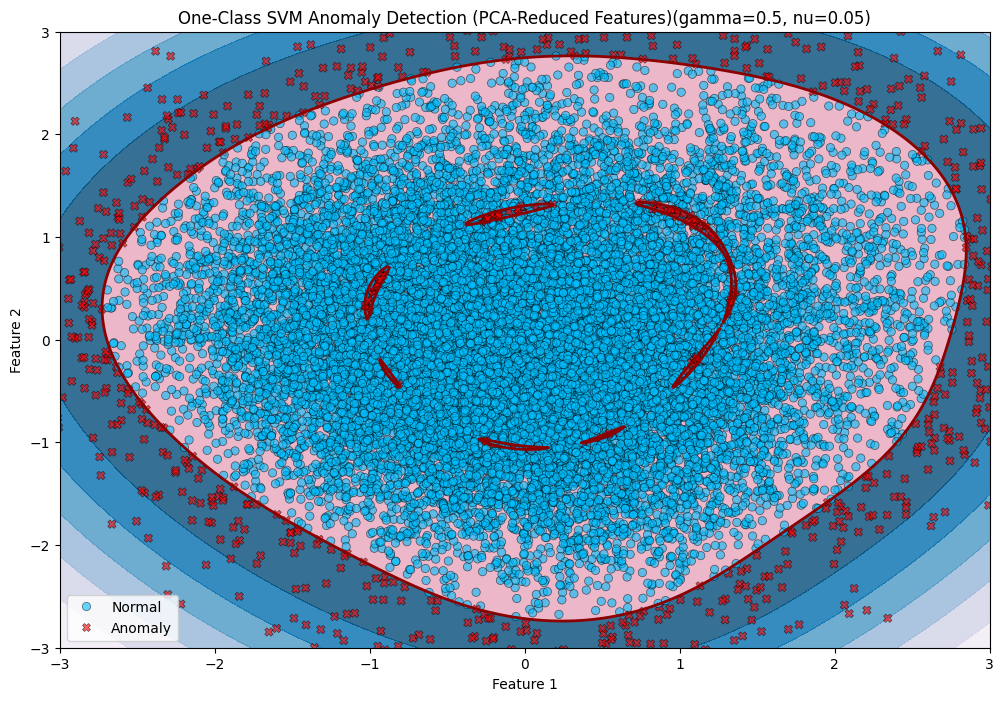

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2 components for visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Use the PCA-transformed data with the One-Class SVM model
model_pca = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
model_pca.fit(X_pca)

# Use existing function with PCA-transformed data
plot_model(model_pca, X_pca, "One-Class SVM Anomaly Detection (PCA-Reduced Features)(gamma=0.5, nu=0.05)")



 ### Apply different combinations of parameter settings

#### Loop to test parameter combinations

In [ ]:
# Quick loop to test parameter combinations
for gamma in ['scale', 0.1, 0.5, 1]:
    for nu in [0.01, 0.03, 0.05, 0.08]:
        model = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
        model.fit(X_scaled)
        preds = model.predict(X_scaled)
        anomaly_pct = (preds == -1).mean() * 100

        print(f"Gamma: {gamma}, Nu: {nu} => Anomalies: {anomaly_pct:.2f}%")


Gamma: scale, Nu: 0.01 => Anomalies: 1.01%
Gamma: scale, Nu: 0.03 => Anomalies: 2.99%
Gamma: scale, Nu: 0.05 => Anomalies: 5.00%
Gamma: scale, Nu: 0.08 => Anomalies: 8.00%
Gamma: 0.1, Nu: 0.01 => Anomalies: 0.97%
Gamma: 0.1, Nu: 0.03 => Anomalies: 3.00%
Gamma: 0.1, Nu: 0.05 => Anomalies: 5.01%
Gamma: 0.1, Nu: 0.08 => Anomalies: 7.99%
Gamma: 0.5, Nu: 0.01 => Anomalies: 3.13%
Gamma: 0.5, Nu: 0.03 => Anomalies: 3.77%
Gamma: 0.5, Nu: 0.05 => Anomalies: 5.34%
Gamma: 0.5, Nu: 0.08 => Anomalies: 8.16%
Gamma: 1, Nu: 0.01 => Anomalies: 9.89%
Gamma: 1, Nu: 0.03 => Anomalies: 9.52%
Gamma: 1, Nu: 0.05 => Anomalies: 9.53%
Gamma: 1, Nu: 0.08 => Anomalies: 10.87%


We can see that our initial choice of gamma=0.5, n=0.05 resulted in 5.34% anomalies, slightly above the desired range (1-5%).

From the results:
* Smaller `nu` values (0.01-0.03) generally provided anomaly percentages comfortably within the 1-5% range.
* The combination **gamma='scale', nu=0.03** (2.99%) and **gamma=0.1, nu=0.03** (3.00%) appear optimal.
* Larger gamma values (0.5-1) increased anomalies significantly beyond the desired threshold.

NB: `gamma='scale'` is a built-in method in scikit-learn which automatically calculates the gamma value as `1 / (n_features * X.var())`. It's adaptive to the data.

Let's now look at the visualisation of 3 combinations of parameters: one that under-detects, one that over-detects, and a final optimal choice.

#### Gamma: 0.1, Nu: 0.01 => Anomalies: 0.97%

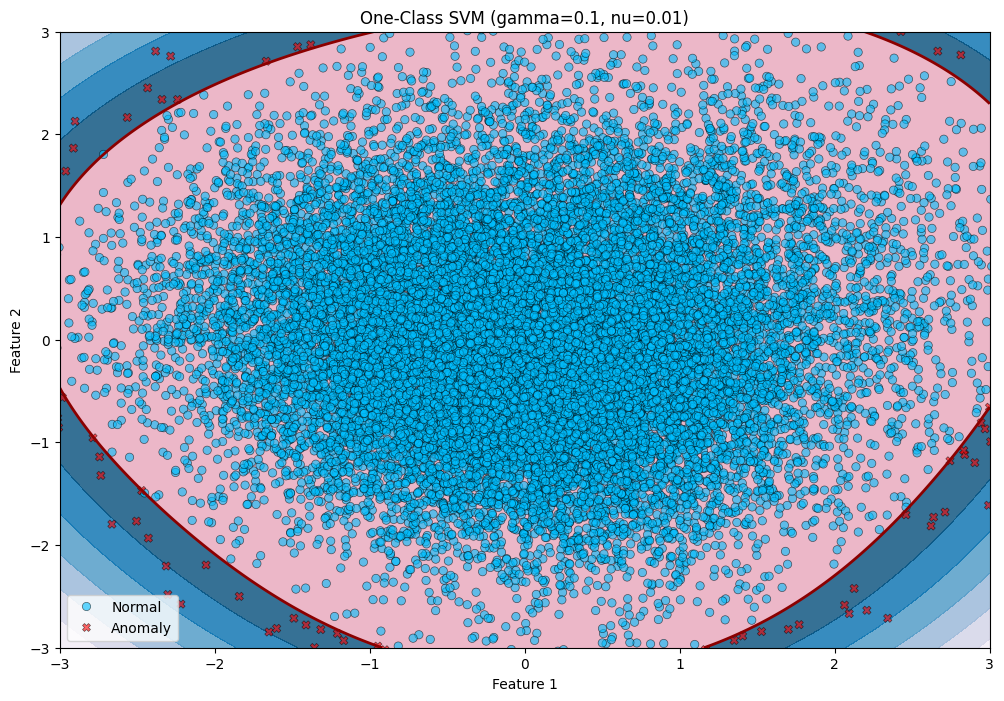

In [ ]:
# One-Class SVM with specified parameters
model_pca = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.01)
model_pca.fit(X_pca)

# Plot
plot_model(model_pca, X_pca, "One-Class SVM (gamma=0.1, nu=0.01)")


#### Gamma: 1, Nu: 0.08 => Anomalies: 10.87%

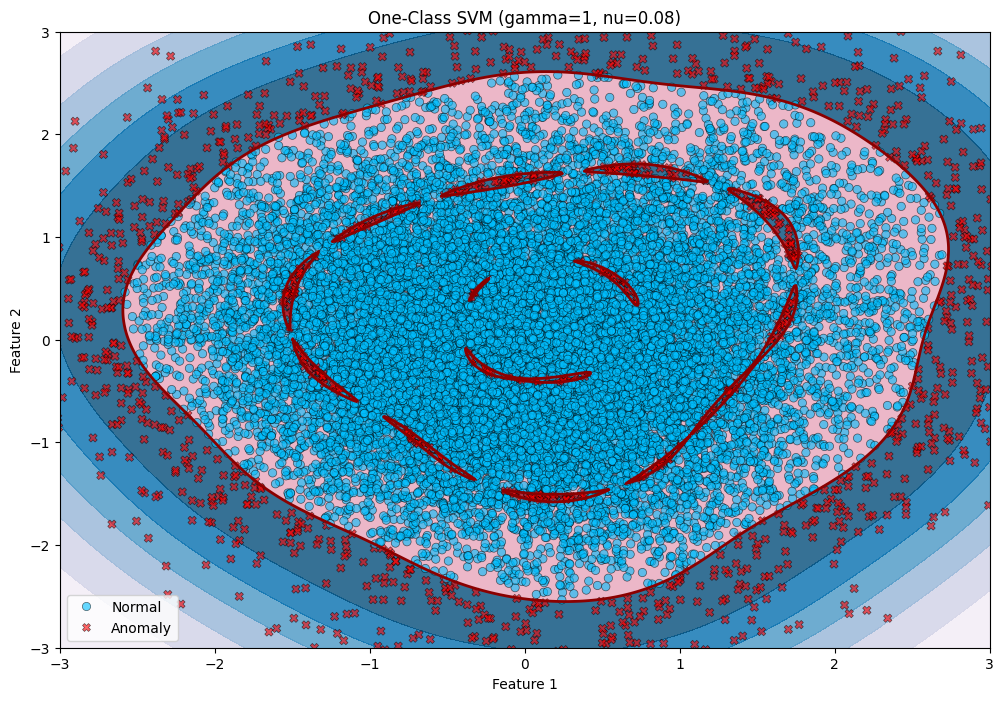

In [ ]:
# One-Class SVM with specified parameters
model_pca = OneClassSVM(kernel='rbf', gamma=1, nu=0.08)
model_pca.fit(X_pca)

# Plot
plot_model(model_pca, X_pca, "One-Class SVM (gamma=1, nu=0.08)")

#### Gamma: 0.1, Nu: 0.03 => Anomalies: 3.00%

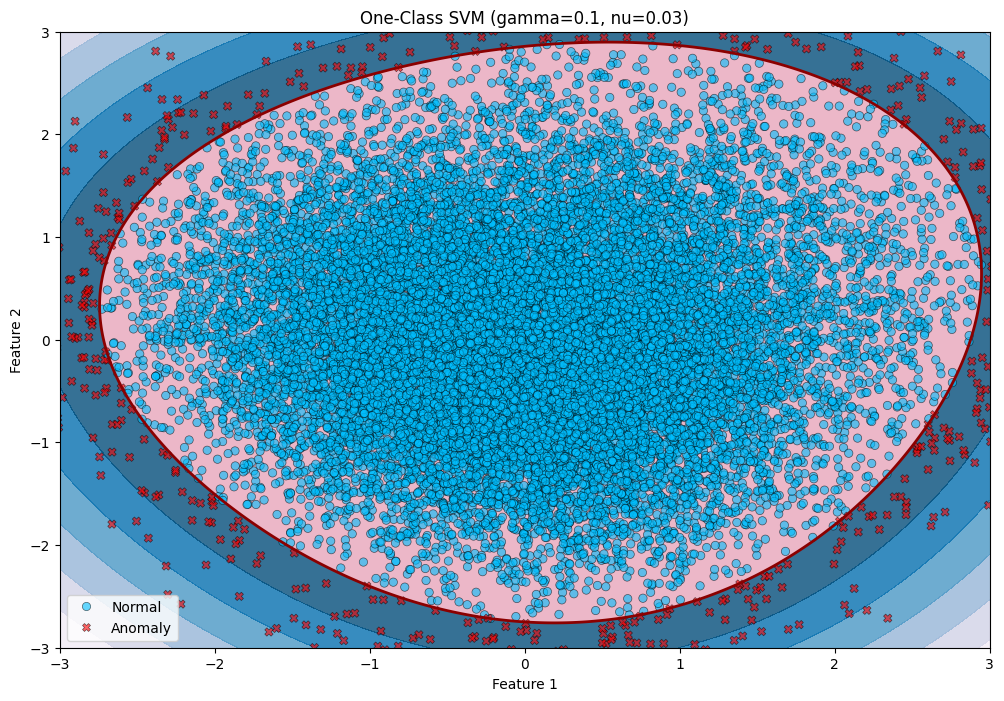

In [ ]:
# One-Class SVM with specified parameters
model_pca = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.03)
model_pca.fit(X_pca)

# Plot
plot_model(model_pca, X_pca, "One-Class SVM (gamma=0.1, nu=0.03)")

### Insights from One-Class SVM method


The One-Class SVM approach is sensitive to parameter selection, especially `nu` and `gamma`. Adjusting `nu` directly controls the fraction of anomalies detected. Setting `gamma=0.1` and `nu=0.03` provided a balanced anomaly rate (3.00%), comfortably within the recommended 1–5% range. Higher gamma values tended to increase anomaly detection excessively, highlighting the importance of careful tuning. Overall, One-Class SVM performed effectively for anomaly detection, provided parameters are chosen thoughtfully and validated visually.

## Using Isolation Forest for Anomaly Detection

### Identify possible anomalies

In [ ]:
# Initialize and fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)

# Predict anomalies (-1 for anomalies, 1 for normal points)
iso_preds = iso_forest.predict(X_scaled)
#print(iso_preds)

# Add predictions to dataframe
df['iso_outlier'] = iso_preds

### Visualise the output in 2D

First we need to do apply dimensional reduction using PCA in order to reduce from 6D to 2D.

In [ ]:
# Perform PCA to reduce dimensionality from 6D to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

 Next, Convert the numerical predictions from Isolation Forest (1 for inliers, -1 for anomalies) into human-readable labels ("Normal" and "Anomaly"). The labels wil be uses for colour coding the data points as Normal or Anomaly.

In [ ]:
# If iso_preds == 1, it returns "Normal". f iso_preds == -1, it returns "Anomaly".
labels = np.where(df['iso_outlier'] == 1, 'Normal', 'Anomaly')
print(labels)

['Normal' 'Anomaly' 'Normal' ... 'Normal' 'Normal' 'Normal']


Next create the scatter plot, ensuring the add the labels.

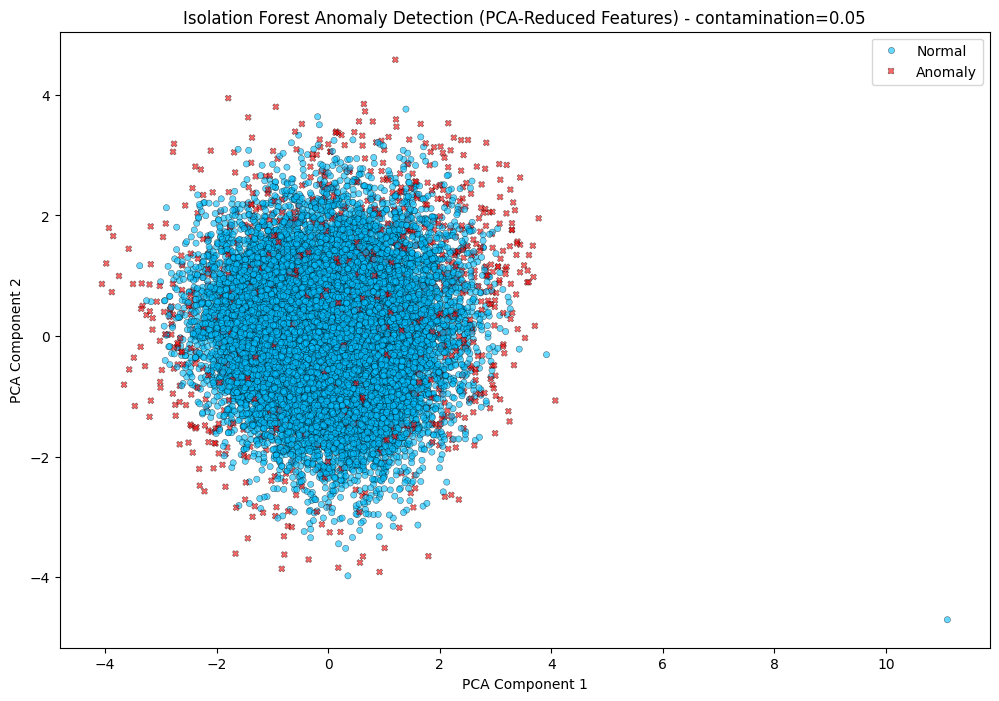

In [ ]:
# Scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, style=labels,
                markers={'Anomaly': 'X', 'Normal': 'o'}, palette={'Normal': 'deepskyblue', 'Anomaly': 'red'},
                alpha=0.6, edgecolor='k', s=20)  # Smaller markers for better clarity

# Top X anomalies could be labeled on the plot.
# However, due to the large dataset size, this made the visualization cluttered rather than useful.
# Labels were omitted for better readability.

plt.title("Isolation Forest Anomaly Detection (PCA-Reduced Features) - contamination=0.05")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

An interesting observation from the PCA visualisation is the presence of an extreme point around PCA Component 1 = 11, which is not flagged as an anomaly by Isolation Forest. While it appears visually distant from the main cluster, Isolation Forest considers feature relationships beyond just PCA-reduced space. This suggests that in the original six-dimensional feature space, the point may not be statistically unusual based on the model's learned structure.

This highlights a key limitation: dimensionality reduction may distort how anomalies are detected. While PCA is useful for visualisation, true anomalies should be verified in the original feature space.

Additionally, I initially considered adding labels in the form of numbers on the datapoints with the most extreme anomalies. However, given the large dataset, this made the plot cluttered and difficult to interpret. For clarity, therefore, the labels were omitted.

To further refine anomaly detection, the next step is to adjust the contamination parameter in Isolation Forest. The current setting of `contamination=0.05` may be too restrictive, potentially under-detecting anomalies. By experimenting with different values, we aim to ensure the percentage of detected anomalies falls within the expected 1-5% range. Since `n_estimators` primarily impacts model stability rather than the proportion of anomalies detected, we will keep it fixed at `100` and focus only on tuning `contamination`.

### Apply different combinations of parameter settings

In [ ]:
# Loop to test different contamination values
for contamination in [0.01, 0.03, 0.05, 0.08, 0.1]:
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    iso_forest.fit(X_scaled)
    preds = iso_forest.predict(X_scaled)
    anomaly_pct = (preds == -1).mean() * 100

    print(f"Contamination: {contamination:.2f} => Anomalies: {anomaly_pct:.2f}%")


Contamination: 0.01 => Anomalies: 1.00%
Contamination: 0.03 => Anomalies: 3.00%
Contamination: 0.05 => Anomalies: 5.00%
Contamination: 0.08 => Anomalies: 8.00%
Contamination: 0.10 => Anomalies: 10.00%


The results from adjusting the contamination parameter show a clear trend in anomaly detection. When set to 0.01 (1%), the model under-detects anomalies, likely missing important outliers. Increasing it to 0.03 (3%) places the anomaly detection rate comfortably within the expected range, making it the most balanced choice. At 0.05 (5%), the detection rate reaches the upper limit of acceptability, but it risks capturing borderline cases that may not be true anomalies. Beyond this, at 0.08 (8%) and 0.10 (10%), the model begins to over-detect anomalies, flagging too many points and reducing confidence in its precision.

Based on these findings, the optimal contamination value is 0.03 (3%), and we will now visualise the results using this setting.

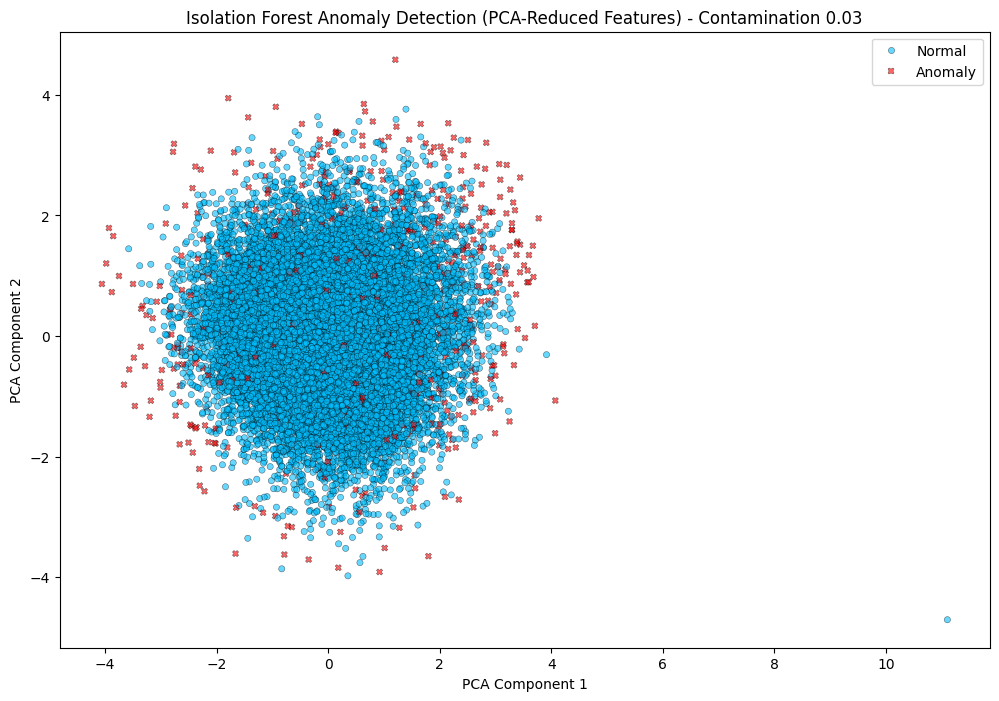

In [ ]:
# Refit Isolation Forest with chosen contamination value
iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
iso_forest.fit(X_scaled)

# Predict anomalies
iso_preds = iso_forest.predict(X_scaled)

# Convert predictions to labels
labels = np.where(iso_preds == 1, 'Normal', 'Anomaly')

# Scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, style=labels,
                markers={'Anomaly': 'X', 'Normal': 'o'}, palette={'Normal': 'deepskyblue', 'Anomaly': 'red'},
                alpha=0.6, edgecolor='k', s=20)

plt.title("Isolation Forest Anomaly Detection (PCA-Reduced Features) - Contamination 0.03")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


The plot doesn't look significantly different, and the extreme point around PCA1 of 11 is still classified as normal. This suggests that adjusting the `contamination` parameter alone isn't enough to refine the detection. Isolation Forest isn't flagging it as an outlier, likely because it considers relationships in the original six-dimensional feature space rather than the PCA-reduced view. The point may not be distant enough from its nearest neighbors in that space. While further adjustments, such as increasing the `n_estimators` parameter, could refine the model, however we will stop the analysis here and not pursue additional parameter tuning.

### Insights from Isolation Forest method

Isolation Forest effectively identified anomalies while keeping the anomaly percentage within the expected range by adjusting the contamination parameter. The final selection of `contamination=0.03` resulted in 3% anomalies, aligning well with expectations. However, one visually extreme point at PCA1 of around 11 remained classified as normal, highlighting a limitation of PCA visualisation for anomaly detection. Since Isolation Forest operates in the original six-dimensional space, it may not have considered the point sufficiently distant. Further refinements, such as adjusting `n_estimators`, could be explored, but the analysis was concluded at this stage.

# Summary of the anomaly detection methods

The anomaly detection process involved both statistical and machine learning methods. The **Interquartile Range (IQR) method** identified outliers based on feature distributions, but it had limitations. Some features had **too few** flagged outliers (e.g., Lubrication Oil Pressure at 0.34%), while others had **too many** (e.g., Lubrication Oil Temperature at 13.4%). This showed that IQR can be inconsistent when applied to different distributions.

Machine learning methods provided a more flexible approach. **One-Class SVM** allowed for fine-tuning using parameters like `gamma` and `nu`. The final choice (`gamma='scale', nu=0.03`) produced **2.99% anomalies**, falling within the expected 1-5% range. **Isolation Forest**, tuned with `contamination=0.03`, identified **3% anomalies**, achieving a similar outcome.

Both ML models performed well, with Isolation Forest being computationally efficient and more intuitive for setting anomaly percentages. One-Class SVM, while effective, required more parameter tuning. PCA visualisation helped assess results but had limitations, as shown by an extreme point that wasn’t flagged as an anomaly in Isolation Forest.

Between the two ML methods, **Isolation Forest was preferred** due to its efficiency, ease of use, and direct control over the expected anomaly percentage. However, IQR remains a simple first-pass approach for detecting individual feature outliers.

# Reflect

This project applied both statistical and machine learning methods for anomaly detection. The IQR method offered a simple baseline but often detected too few or too many outliers. Machine learning models, particularly Isolation Forest, provided more adaptive and reliable results. While PCA-based 2D visualisations helped illustrate anomaly separation, they did not always reflect the true structure in higher dimensions. The project underscored the value of methods that balance interpretability, efficiency, and performance within a defined anomaly range of 1–5%.

### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]